In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# from xgboost import XGBRegressor, plot_tree
# import xgboost as xgb
# import lightgbm as lgb

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [105]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'C:\\2023_11-PTSFC\\data_prepro.py'>

### Data Prep

In [106]:
# ITERATIVE FCAST ... 1/2 day each time ... 6 times = 3 days ahead

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current time
t_now = pd.Timestamp.now(tz='CET')
# set time to 00:00
t_now = t_now.replace(hour=0, minute=0, second=0, microsecond=0)

# - - - - - - - - - - - - -
t_now = pd.Timestamp(year=2023, month=1, day=18, hour=0, minute=0, second=0, microsecond=0)
# - - - - - - - - - - - - -

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday of this week
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

wed = 2023-01-18 00:00:00
thu = 2023-01-19 00:00:00
C:\2023_11-PTSFC
to_date is earlier than 2023-11-01, using historic data only !
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70561 entries, 2014-12-31 23:00:00+00:00 to 2023-01-18 23:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  70561 non-null  datetime64[ns, CET]
 1   gesamt         70561 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.6 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2023-01-18 19:00:00+00:00,2023-01-18 20:00:00+01:00,63626.00
2023-01-18 20:00:00+00:00,2023-01-18 21:00:00+01:00,61295.00
2023-01-18 21:00:00+00:00,2023-01-18 22:00:00+01:00,58729.25
2023-01-18 22:00:00+00:00,2023-01-18 23:00:00+01:00,55376.50
2023-01-18 23:00:00+00:00,2023-01-19 00:00:00+01:00,13380.50


In [107]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2022-01-01'
end     = '2024-01-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
print(df_energy_small.info())

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9192 entries, 2022-01-01 00:00:00+00:00 to 2023-01-18 23:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  9192 non-null   datetime64[ns, CET]
 1   gesamt         9192 non-null   float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 215.4 KB
None


### Model Train

In [108]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

In [109]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

# !!! IMPORTANT !!!
# check best params ... alpha = ??? 

print('- '*15)  
print(f'> start training quantile regression models ...')
all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print(quantile_regressor.intercept_)
    # df_coef_w_names = pd.DataFrame(quantile_regressor.coef_, index=quantile_regressor.feature_names_in_)
    # print(df_coef_w_names.to_string())

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


In [110]:
# - - - - - - - - - -
# gradient boosting with features

# !!! IMPORTANT !!! 
# grid search for best params
# for each quantile ???

# common_params = dict(
#     learning_rate=0.3,
#     max_depth=7,
#     min_samples_leaf=5,
#     n_estimators=300, 
#     subsample=0.9
# )
    
quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 400, 'subsample': 0.9}, 
                   0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 250, 'subsample': 0.7},
                   0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.8},
                   0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 250, 'subsample': 0.7},
                   0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.7}}

# quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7}, 
#                    0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6},
#                    0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6},
#                    0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7},
#                    0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6}}

print('- '*15)  
print(f'> start training gradient boosting models ...')
all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')

    params = quantile_params[alpha]
    # pprint(params)

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)


- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


### Forecast from Thursday

In [111]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'C:\\2023_11-PTSFC\\data_prepro.py'>

In [112]:
# ITERATIVE FCAST ... 1/2 day each time ... 6 times = 3 days ahead

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically
t_now = pd.Timestamp.now(tz='CET')
# set time to 00:00
t_now = t_now.replace(hour=0, minute=0, second=0, microsecond=0)
# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday of this week
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()

wed = 2024-01-03 00:00:00+01:00
thu = 2024-01-04 00:00:00+01:00
C:\2023_11-PTSFC
to_date is later than 2023-11-01, using historic and recent data !
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


2023-12-27 22:00:00+00:00 2024-01-03 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-03 23:00:00+00:00', '2024-01-04 00:00:00+00:00',
               '2024-01-04 01:00:00+00:00', '2024-01-04 02:00:00+00:00',
               '2024-01-04 03:00:00+00:00', '2024-01-04 04:00:00+00:00',
               '2024-01-04 05:00:00+00:00', '2024-01-04 06:00:00+00:00',
               '2024-01-04 07:00:00+00:00', '2024-01-04 08:00:00+00:00',
               '2024-01-04 09:00:00+00:00', '2024-01-04 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


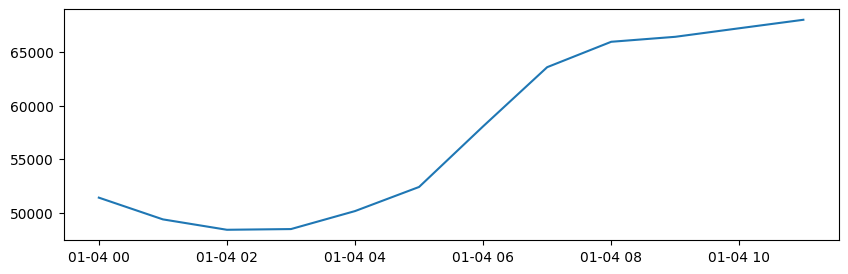

new end timestamp: 2024-01-04 10:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-04 11:00:00+00:00', '2024-01-04 12:00:00+00:00',
               '2024-01-04 13:00:00+00:00', '2024-01-04 14:00:00+00:00',
               '2024-01-04 15:00:00+00:00', '2024-01-04 16:00:00+00:00',
               '2024-01-04 17:00:00+00:00', '2024-01-04 18:00:00+00:00',
               '2024-01-04 19:00:00+00:00', '2024-01-04 20:00:00+00:00',
               '2024-01-04 21:00:00+00:00', '2024-01-04 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


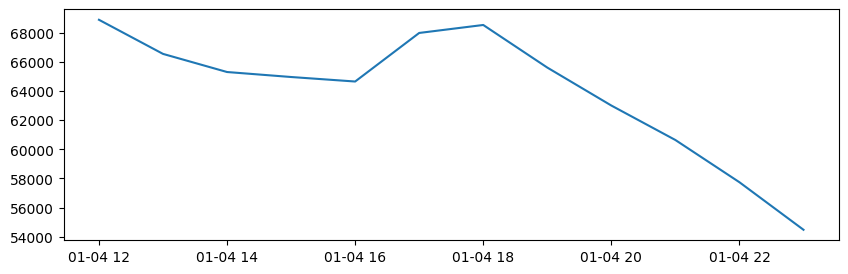

new end timestamp: 2024-01-04 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-04 23:00:00+00:00', '2024-01-05 00:00:00+00:00',
               '2024-01-05 01:00:00+00:00', '2024-01-05 02:00:00+00:00',
               '2024-01-05 03:00:00+00:00', '2024-01-05 04:00:00+00:00',
               '2024-01-05 05:00:00+00:00', '2024-01-05 06:00:00+00:00',
               '2024-01-05 07:00:00+00:00', '2024-01-05 08:00:00+00:00',
               '2024-01-05 09:00:00+00:00', '2024-01-05 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


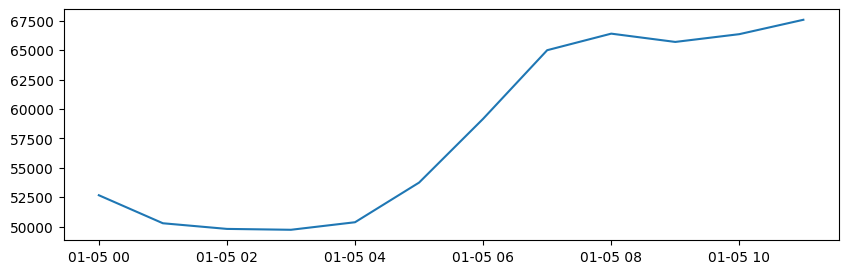

new end timestamp: 2024-01-05 10:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-05 11:00:00+00:00', '2024-01-05 12:00:00+00:00',
               '2024-01-05 13:00:00+00:00', '2024-01-05 14:00:00+00:00',
               '2024-01-05 15:00:00+00:00', '2024-01-05 16:00:00+00:00',
               '2024-01-05 17:00:00+00:00', '2024-01-05 18:00:00+00:00',
               '2024-01-05 19:00:00+00:00', '2024-01-05 20:00:00+00:00',
               '2024-01-05 21:00:00+00:00', '2024-01-05 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


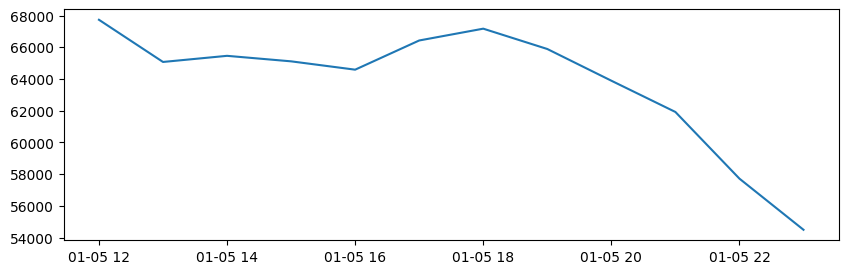

new end timestamp: 2024-01-05 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-05 23:00:00+00:00', '2024-01-06 00:00:00+00:00',
               '2024-01-06 01:00:00+00:00', '2024-01-06 02:00:00+00:00',
               '2024-01-06 03:00:00+00:00', '2024-01-06 04:00:00+00:00',
               '2024-01-06 05:00:00+00:00', '2024-01-06 06:00:00+00:00',
               '2024-01-06 07:00:00+00:00', '2024-01-06 08:00:00+00:00',
               '2024-01-06 09:00:00+00:00', '2024-01-06 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


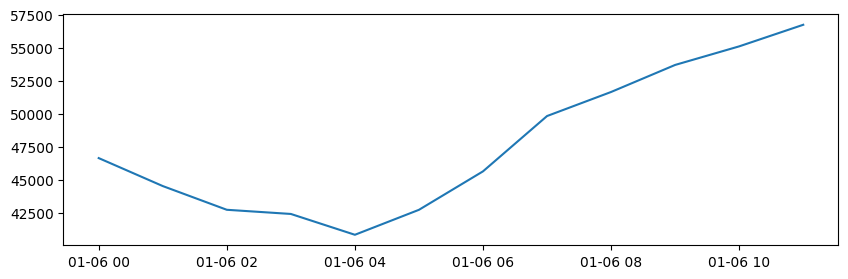

new end timestamp: 2024-01-06 10:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-06 11:00:00+00:00', '2024-01-06 12:00:00+00:00',
               '2024-01-06 13:00:00+00:00', '2024-01-06 14:00:00+00:00',
               '2024-01-06 15:00:00+00:00', '2024-01-06 16:00:00+00:00',
               '2024-01-06 17:00:00+00:00', '2024-01-06 18:00:00+00:00',
               '2024-01-06 19:00:00+00:00', '2024-01-06 20:00:00+00:00',
               '2024-01-06 21:00:00+00:00', '2024-01-06 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


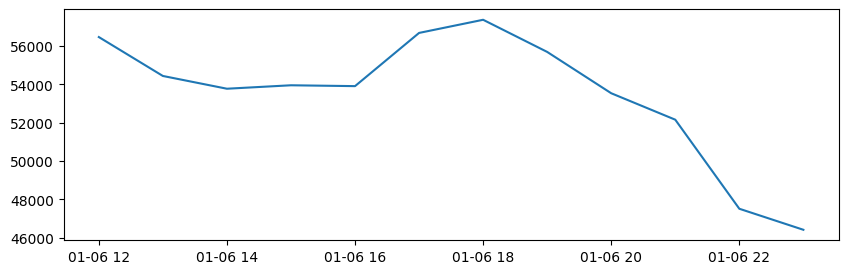

= = = = = = = = = = = = = = = 
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-03 23:00:00+00:00,43336.134512,48310.323915,51423.299094,53026.733632,55286.250229
2024-01-04 00:00:00+00:00,42358.021111,46917.331575,49399.990797,51026.472949,53436.262881
2024-01-04 01:00:00+00:00,41355.232044,45554.663115,48431.573856,50356.904573,53102.699336
2024-01-04 02:00:00+00:00,41767.429593,46221.663960,48497.817489,50403.017420,52462.157428
2024-01-04 03:00:00+00:00,42722.652426,47257.751813,50172.305484,51339.023790,53018.512123
...,...,...,...,...,...
2024-01-06 18:00:00+00:00,51118.887217,54218.523307,55689.980241,57282.346055,62358.938509
2024-01-06 19:00:00+00:00,48685.951745,52397.283482,53535.327805,55379.778128,60439.873218
2024-01-06 20:00:00+00:00,45793.201957,49604.888773,52156.111496,52358.142702,59423.493529
2024-01-06 21:00:00+00:00,42623.022326,45189.827253,47512.990666,49238.690803,54845.195203


In [113]:
# take smaller dataset
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_all = pd.DataFrame()

for fcast_iter in range(6):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print('- '*15) 
    print(f"> to be forecasted")
    print(fcast_timestamp_UTC)

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    plt.figure(figsize=(10,3))
    plt.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)
    plt.show()

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_all = pd.concat((df_fcast_all, df_ens_fcast_out))

print('= '*15)
print('= '*15)
print(f"all iterative fcasts done ...")
display(df_fcast_all)

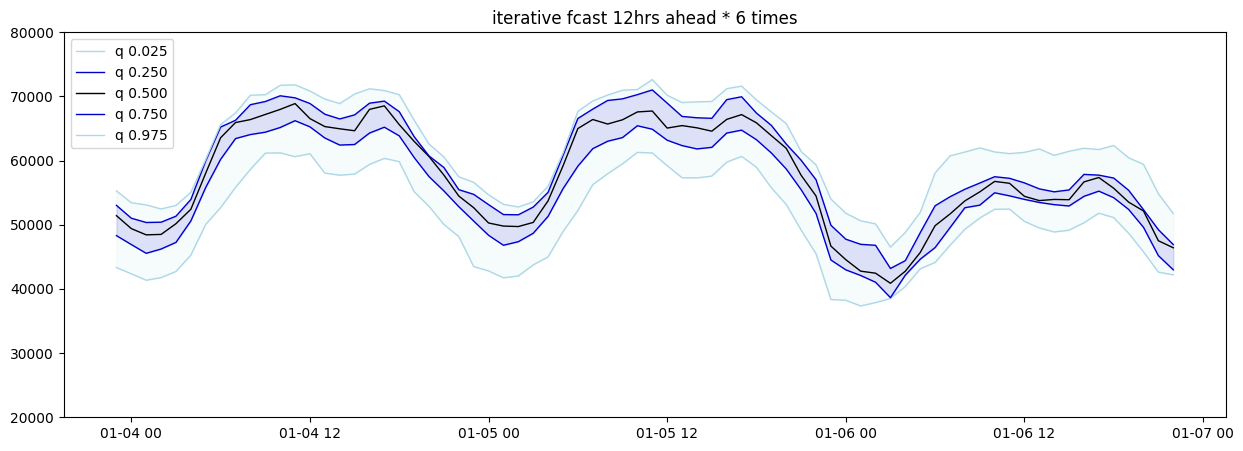

In [119]:
df_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_all)

plt.figure(figsize=(15, 5))
plt.title(f'iterative fcast 12hrs ahead * 6 times')

df = df_fcast_all_fixed.copy()

for quantile in df.columns:

    y_pred = df[quantile]
    quantile_float = float(quantile[2:])

    # Save predicted values based on quantile
    if '0.025' in quantile:
        y_pred_025 = y_pred
        col = 'lightblue'
    elif '0.25' in quantile:
        y_pred_25 = y_pred
        col = 'mediumblue'
    elif '0.5' in quantile:
        y_pred_50 = y_pred
        col = 'black'
    elif '0.75' in quantile:
        y_pred_75 = y_pred
        col = 'mediumblue'
    elif '0.975' in quantile:
        y_pred_975 = y_pred
        col = 'lightblue'
    
    # Plot the prediction line
    plt.plot(df.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

plt.fill_between(df.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
plt.fill_between(df.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

plt.ylim(20_000, 80_000)
plt.legend()
plt.show()

In [ ]:
# current index is utc
# add cet col and get required submission horizons
# turn to array and div by 1000
np.array(df/1000)